### Week 3 Project

In [217]:
#import the libraries
import numpy as np
import pandas as pd
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Let's scrap the data from wikipedia page, [List of postal codes of Canada: M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [179]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)[0]

### First task

In [180]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We will get only data, where Borough is present 

In [181]:
df = df[df['Borough'] != "Not assigned"]

As some rows has got deleted , We need to reset the index

In [182]:
df.reset_index(inplace=True)

In [183]:
df.head()

,index,Postal Code,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [184]:
len(df['Postal Code']) == len(pd.unique(df['Postal Code']))

True

Postal Code column has all unique values

In [185]:
(df['Neighbourhood']== "Not assigned").sum()

0

There is no neighbourhood which is Not assigned

In [186]:
df.shape

(103, 4)

## Second Task

Get the geospatial Coordinates from given csv file , and merge it with our data frame 

In [187]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv')

In [188]:
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [189]:
df1 =df.merge(coordinates, left_on = 'Postal Code',right_on = 'Postal Code', how= 'left')

In [190]:
df1.head()

,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,2,M3A,North York,Parkwoods,43.753259,-79.329656
1,3,M4A,North York,Victoria Village,43.725882,-79.315572
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Third Task

In [191]:
import folium # map rendering library


In [192]:
toronto_data = df1[df1['Borough'].apply(lambda x : x.split()[-1]) == 'Toronto']

In [193]:
toronto_data.reset_index(inplace=True)
toronto_data.head()

,level_0,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,9,13,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,15,22,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,19,30,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [194]:
latitude = toronto_data['Latitude'][0]
longitude = toronto_data['Longitude'][0]

In [195]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    

map_toronto

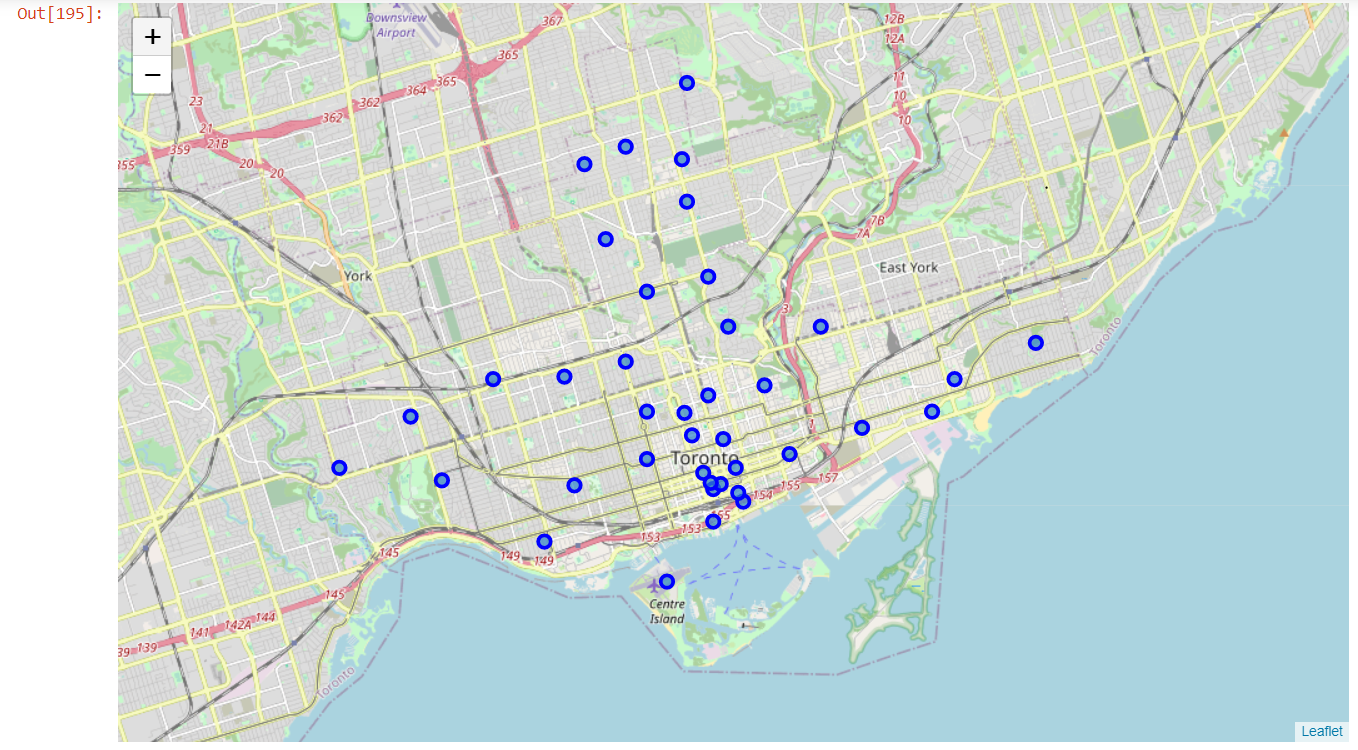

## Use foursqure API to get Neighbourhood

In [1]:
# define Foursquare Credentials and Version
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxx
CLIENT_SECRET:xxx


Lets get the top 100 places within 500 meters

In [197]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Postal Code'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [198]:
# convert the venues list into a new DataFrame
venues_data = pd.DataFrame(venues)

# define the column names
venues_data.columns = ['Postal Code', 'Borough', 'Neighbourhood', 'Borough Latitude', 'Borough Longitude', 'Venue Name', 
                       'Venue Latitude', 'Venue Longitude', 'Venue Category']

venues_data.head()

,Postal Code,Borough,Neighbourhood,Borough Latitude,Borough Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [199]:
venues_data.groupby(by=['Postal Code','Borough','Neighbourhood']).count().head()

,,,Borough Latitude,Borough Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Postal Code,Borough,Neighbourhood,,,,,,
M4E,East Toronto,The Beaches,4,4,4,4,4,4
M4K,East Toronto,"The Danforth West, Riverdale",44,44,44,44,44,44
M4L,East Toronto,"India Bazaar, The Beaches West",19,19,19,19,19,19
M4M,East Toronto,Studio District,37,37,37,37,37,37
M4N,Central Toronto,Lawrence Park,3,3,3,3,3,3


In [200]:
print('There are {} unique types of places '.format(len(venues_data['Venue Category'].unique())))

There are 240 unique types of places 


### Analyze Each Area

In [201]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_data[['Venue Category']], prefix="", prefix_sep="")
#add the Posatal code, Borough, Neighbourhood to data frame

toronto_onehot['Postal Code'] = venues_data['Postal Code']
toronto_onehot['Borough'] = venues_data['Borough']
toronto_onehot['Neighbourhood'] = venues_data['Neighbourhood']
toronto_onehot.shape

(1639, 243)

In [202]:
toronto_onehot.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio,Postal Code,Borough,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [203]:
toronto_onehot = toronto_onehot[list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])]

In [204]:
toronto_onehot

,Postal Code,Borough,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [205]:
toronto_grouped = toronto_onehot.groupby(["Postal Code", "Borough", "Neighbourhood"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(39, 243)


,Postal Code,Borough,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,M4K,East Toronto,"The Danforth West, Riverdale",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.022727,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.022727
2,M4L,East Toronto,"India Bazaar, The Beaches West",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,M4M,East Toronto,Studio District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.027027,0.00,0.027027
4,M4N,Central Toronto,Lawrence Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,M4P,Central Toronto,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.055556
7,M4S,Central Toronto,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029412,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,M4T,Central Toronto,"Moore Park, Summerhill East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.071429,0.000000,0.00,0.000000


In [206]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['Postal Code']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(39, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,M4K,East Toronto,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Furniture / Home Store,Restaurant,Ice Cream Shop,Cosmetics Shop,Caribbean Restaurant,Pub
2,M4L,East Toronto,"India Bazaar, The Beaches West",Park,Gym,Pub,Brewery,Liquor Store,Sandwich Place,Burrito Place,Italian Restaurant,Restaurant,Fast Food Restaurant
3,M4M,East Toronto,Studio District,Coffee Shop,Bakery,Café,Gastropub,American Restaurant,Brewery,Bar,Ice Cream Shop,Fish Market,Italian Restaurant
4,M4N,Central Toronto,Lawrence Park,Park,Bus Line,Swim School,Dim Sum Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
5,M4P,Central Toronto,Davisville North,Department Store,Sandwich Place,Dance Studio,Hotel,Food & Drink Shop,Dog Run,Breakfast Spot,Gym / Fitness Center,Park,Dumpling Restaurant
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",Coffee Shop,Clothing Store,Yoga Studio,Spa,Restaurant,Bagel Shop,Ice Cream Shop,Diner,Sporting Goods Shop,Fast Food Restaurant
7,M4S,Central Toronto,Davisville,Dessert Shop,Sandwich Place,Pizza Place,Gym,Italian Restaurant,Café,Coffee Shop,Sushi Restaurant,Pharmacy,Seafood Restaurant
8,M4T,Central Toronto,"Moore Park, Summerhill East",Playground,Trail,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",Coffee Shop,Pizza Place,Light Rail Station,Liquor Store,Restaurant,Bank,Bagel Shop,Pub,Supermarket,Fried Chicken Joint


### Cluster Neighborhood

Run k-means to cluster the neighborhood into 5 clusters.

In [207]:

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(["Postal Code", "Borough", "Neighbourhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 0, 0, 0, 2, 0])

In [208]:

# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_data.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), left_on="Postal Code", right_on='PostalCode')
toronto_merged.drop(["level_0", "index"], axis=1, inplace=True)

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(39, 18)


,level_0,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
1,4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,9,13,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
3,15,22,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
4,19,30,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [209]:

# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged

(39, 18)


,level_0,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
20,67,102,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,Department Store,Sandwich Place,Dance Studio,Hotel,Food & Drink Shop,Dog Run,Breakfast Spot,Gym / Fitness Center,Park,Dumpling Restaurant
21,68,103,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,0,Sushi Restaurant,Park,Mexican Restaurant,Jewelry Store,Trail,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
24,74,112,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0,Sandwich Place,Café,Coffee Shop,Park,History Museum,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,Donut Shop,Pub
25,75,113,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,0,Breakfast Spot,Gift Shop,Dessert Shop,Cuban Restaurant,Eastern European Restaurant,Dog Run,Bar,Italian Restaurant,Restaurant,Movie Theater
26,79,120,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Dessert Shop,Sandwich Place,Pizza Place,Gym,Italian Restaurant,Café,Coffee Shop,Sushi Restaurant,Pharmacy,Seafood Restaurant
27,80,121,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,0,Café,Bookstore,Bar,Japanese Restaurant,Sandwich Place,Bakery,Yoga Studio,Pub,Beer Bar,Beer Store
28,81,122,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,0,Café,Coffee Shop,Pub,Pizza Place,Sushi Restaurant,Italian Restaurant,Yoga Studio,Gourmet Shop,Salon / Barbershop,Restaurant
29,83,129,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,Playground,Trail,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
30,84,130,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,0,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar,Coffee Shop,Café,Vietnamese Restaurant,Pizza Place,Park,Burger Joint,Dumpling Restaurant


Finally, let's visualize the resulting clusters

In [220]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postal Code'], toronto_merged['Borough'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

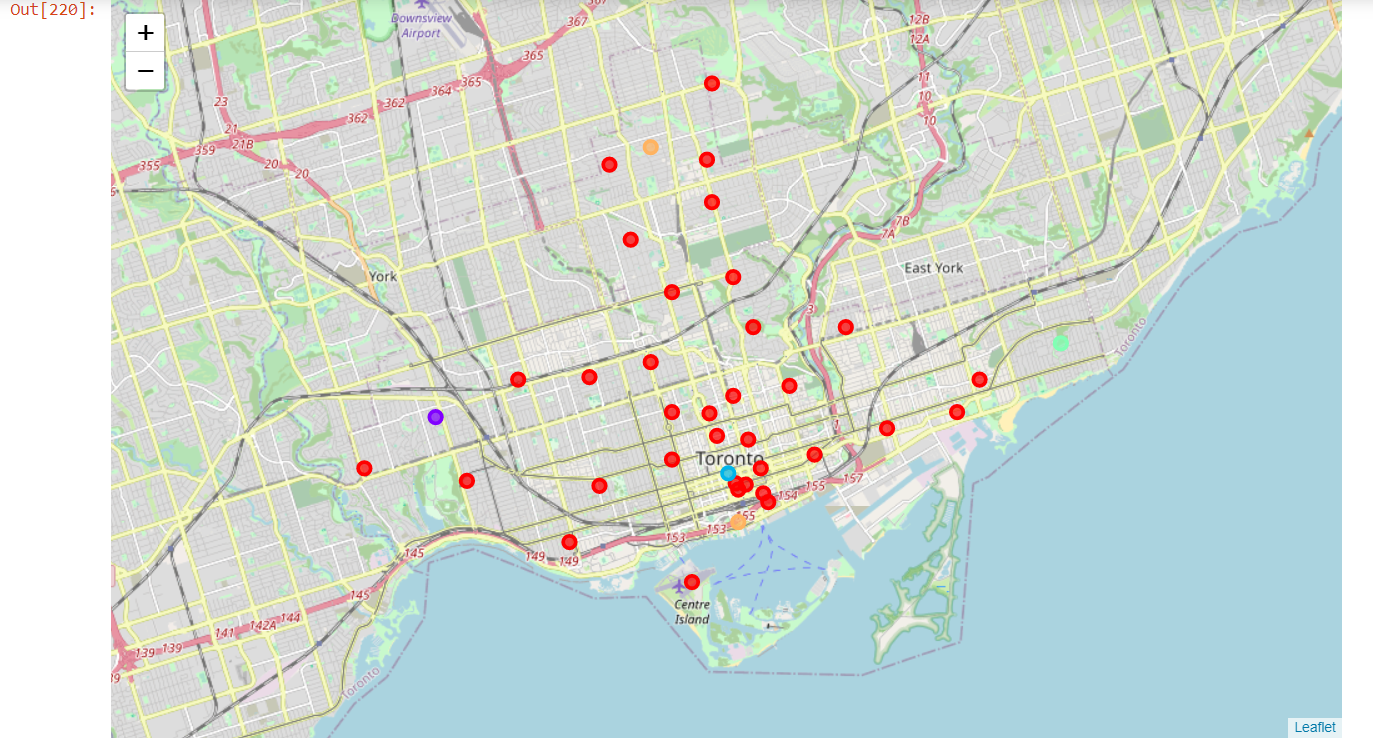

### Examine Clusters

#### Cluster 1

In [221]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
20,Central Toronto,0,Department Store,Sandwich Place,Dance Studio,Hotel,Food & Drink Shop,Dog Run,Breakfast Spot,Gym / Fitness Center,Park,Dumpling Restaurant
21,Central Toronto,0,Sushi Restaurant,Park,Mexican Restaurant,Jewelry Store,Trail,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
24,Central Toronto,0,Sandwich Place,Café,Coffee Shop,Park,History Museum,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,Donut Shop,Pub
25,West Toronto,0,Breakfast Spot,Gift Shop,Dessert Shop,Cuban Restaurant,Eastern European Restaurant,Dog Run,Bar,Italian Restaurant,Restaurant,Movie Theater
26,Central Toronto,0,Dessert Shop,Sandwich Place,Pizza Place,Gym,Italian Restaurant,Café,Coffee Shop,Sushi Restaurant,Pharmacy,Seafood Restaurant
27,Downtown Toronto,0,Café,Bookstore,Bar,Japanese Restaurant,Sandwich Place,Bakery,Yoga Studio,Pub,Beer Bar,Beer Store
28,West Toronto,0,Café,Coffee Shop,Pub,Pizza Place,Sushi Restaurant,Italian Restaurant,Yoga Studio,Gourmet Shop,Salon / Barbershop,Restaurant
29,Central Toronto,0,Playground,Trail,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
30,Downtown Toronto,0,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar,Coffee Shop,Café,Vietnamese Restaurant,Pizza Place,Park,Burger Joint,Dumpling Restaurant


#### Cluster 2

In [224]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,West Toronto,1,Mexican Restaurant,Bar,Thai Restaurant,Café,Arts & Crafts Store,Discount Store,Flea Market,Diner,Italian Restaurant,Bakery


#### Cluster 3

In [225]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Downtown Toronto,2,Coffee Shop,Café,Gym,Restaurant,Hotel,Clothing Store,Thai Restaurant,Bar,Sushi Restaurant,Bookstore


#### Cluster 4

In [226]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,3,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


#### cluster 5

In [228]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,4,Coffee Shop,Clothing Store,Yoga Studio,Spa,Restaurant,Bagel Shop,Ice Cream Shop,Diner,Sporting Goods Shop,Fast Food Restaurant
10,Downtown Toronto,4,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Restaurant,Scenic Lookout,Brewery,Pizza Place,Bar


Cluster 1 has lot more neighborhood ,  From map we can see that cluster 1 applears in Downltown and densly populated regin 